# TFC - DEISI258 - Modelamento multi-agente de interações em grupos sociais

Aluno: **Paulo Pinto** a21906966

Orientador: **Manuel Marques Pita**


Neste notebook:
- É feita a conexão ao NetLogo através da biblioteca pyNetLogo
- É carregado o modelo desenvolvido para o âmbito do TFC
- Podem ser corridas as simulações com os parâmetros desejados (neste caso 12 cenários simulados 50 vezes durante 300 iterações, para obter significância estatística
- Os dados são visualizados e analisados

## Setup

### Setup Virtual Environment

Create virtual environment 'tfc_venv' -> `python -m venv tfc_venv` or `python[version_number] -m venv tfc_venv`

Activate 'tfc_venv' -> Linux `source tfc_venv/bin/activate` | Windows `. tfc_venv\scripts\activate`

Install required packages -> `pip install -r requirements.txt`

Errors - 
- `No module named 'pip'` -> python -m ensurepip
- `No module named 'jpype'` -> pip install jpype1

### Imports

In [2]:
import os
from sys import platform

import pyNetLogo

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from collections import Counter

import seaborn as sns

### Connect to NetLogo

In [3]:
# check if NetLogo env var exists
if "NetLogo" in os.environ: 
    print(f"{os.environ['NetLogo']=}")
else:
    print("NetLogo not found in environment variables, adding it...")

    # substitute with your NetLogo installation path
    if platform == "linux":
        os.environ["NetLogo"] = "/home/paulo/Desktop/TFC/NetLogo-6.2.1-64/NetLogo 6.2.1"

os.environ['NetLogo']='D:\\Netlogo'


### Load model

In [4]:
# connect to netlogo
netlogo = pyNetLogo.NetLogoLink(
    gui=False,
    netlogo_home = os.environ['NetLogo'],
    netlogo_version="6.2",
)

def load_model():
    if platform == "linux":
        model_path = os.path.abspath(os.getcwd()) + "/files/knowledge_units_with_board.nlogo"    
    elif platform == "win32":
        model_path = os.path.abspath(os.getcwd()) + "\\files\\knowledge_units_with_board.nlogo"

    netlogo.load_model(model_path)
    # netlogo.command("setup")

load_model()

## Get simulation data

### Helper Functions

In [6]:
def fix_col_names(df):
    df.rename(columns = {
        'compat_ratio':'Topic Divergence',
        '[ratio] of one-of boards':'Avg Compat Ratio',
        'length last [board_history] of one-of boards':'Burst Length',
        '[male_participation] of one-of boards':'Male Participation',
        '[female_participation] of one-of boards':'Female Participation',
    }, inplace = True)
    return df

# gets messages, returns in/out of topic lengths
# [1, 0, 0, 0, 1, 1] -> [[3], [1, 2]]
def split_topics(messages):
    topic = [[],[]]

    prev_compat = 1

    for curr_compat in messages:
        if curr_compat == -1 or curr_compat == "-1": curr_compat = 0
        if prev_compat == curr_compat: # continue last count
            topic[curr_compat][len(topic[curr_compat]) - 1] += 1
        else: # create new count
            topic[curr_compat].append(1)
        
        prev_compat = curr_compat
    
    return topic

### Set Simulation Parameters

In [7]:
# sim options
simulation_reports = []
simulation_times = 50
iterations = 300

reported_columns = [
    "compat_ratio", 
    "[ratio] of one-of boards", 
    "length last [board_history] of one-of boards"
]

# Agent properties
m_exploit_rate = 0.4
f_exploit_rate = 0.6
posting_chance = 0.8

netlogo.command(f"set female_prob_exploit {f_exploit_rate}")
netlogo.command(f"set male_prob_exploit {m_exploit_rate}")
netlogo.command(f"set posting_chance {posting_chance}")
netlogo.command("set number_of_agents 15")
netlogo.command(f'set Method "Attention Norm"')

# create path if it doesnt exist yet
folder_path = f"outputs/sim_{f_exploit_rate}fx_{m_exploit_rate}mx_{posting_chance}pc"
if not os.path.exists(folder_path): os.makedirs(folder_path) 

# testing with posting chance at 80%   

### Run Simulation + Write to file 

In [67]:
for i in range(1, simulation_times + 1):
    netlogo.command("setup")
    
    report = netlogo.repeat_report(reported_columns, iterations)
    report = fix_col_names(report)

    # write to file
    report.to_csv(f"{folder_path}/{i}.csv")
    
    simulation_reports.append(report)
    
    print(i)

14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 8 | M - 7
1
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 7 | M - 8
2
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 8 | M - 7
3
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 7 | M - 8
4
14 agents left
13 agents

## Read Files + Generate Plots

### Helper Functions

In [8]:
# plot overlapping histogram for in/out topic
def plot_topic_histogram(in_topic, out_topic, method, normalised=False):
    fig = plt.figure(figsize=(10,4))
    fig.patch.set_facecolor('white')

    common_params = {
        "bins" : range(min(in_topic), max(in_topic) + 1, 1),
        "edgecolor" : "black",
        "alpha" : 0.3,
        "density" : normalised
    }

    plt.hist(in_topic, label="in topic", color="red", **common_params)
    plt.hist(out_topic, label="out of topic", **common_params)
    plt.xlabel("Length", size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"Length of In-Topic and Out-of-Topic discussion - {method=}")
    plt.legend(loc='upper right')
    plt.show()

# plot either in or out
def plot_one_topic_histogram(topic, topic_type, info, normalised=False, xlim = 100):
    fig = plt.figure(figsize=(10,4))
    fig.patch.set_facecolor('white')

    common_params = {
        "bins" : range(min(in_topic), max(in_topic) + 1, 1),
        "edgecolor" : "black",
        "color" : "blue" if topic_type == "in" else "red",
        "alpha" : 1,
        "density" : normalised
    }
        
    plt.hist(topic, label=f"{topic_type} topic", **common_params)
    plt.xlabel("Length", size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"Length of {topic_type}-Topic discussion - {info}")
    plt.legend(loc='upper right')
    
    plt.xlim(0, xlim)
   
    if normalised and xlim == 100:
        plt.ylim(top=0.4)
        pass
    
    plt.savefig(f"{folder_path}/{topic_type}{('_norm' * normalised)}{'_unlimited' * (xlim != 100)}.png")
    plt.show()

### Plot individual Histograms for In/Out of Topic

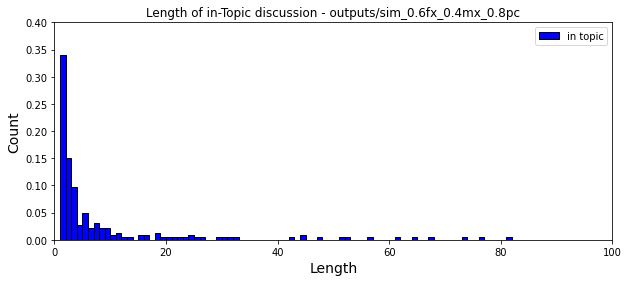

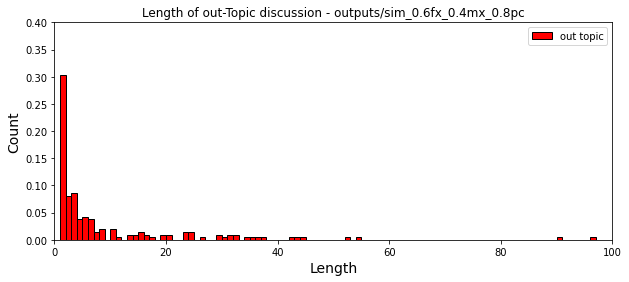

In [9]:
# stores in/out-topic data from all simulations on provided folder
in_topic = []
out_topic = []

for i in range(1, simulation_times + 1):
    curr_path = f"{folder_path}/{i}.csv"
        
    df = pd.read_csv(curr_path)
    
    in_, out_ = split_topics(df["Topic Divergence"].astype(int))
    in_topic += in_
    out_topic += out_

plot_one_topic_histogram(in_topic, "in", folder_path, normalised = True)
plot_one_topic_histogram(out_topic, "out", folder_path, normalised = True)

### Plot both Histograms (with Overlap)

In [ ]:
# in_topic = []
# out_topic = []

# for i in range(1, simulation_times + 1):
#     curr_path = f"{folder_path}/{i}.csv"
#     # print(x.to_string())
    
#     df = pd.read_csv(curr_path)
#     # print(x.to_string())
#     in_, out_ = split_topics(df["Topic Divergence"].astype(int))
#     in_topic += in_
#     out_topic += out_

# plot_topic_histogram(in_topic, out_topic, method = "Old", normalised = False)
# plot_topic_histogram(in_topic, out_topic, method = "Old", normalised = True)

### Visualize Burst Length

In [ ]:
iterations = 200
repeat_report = netlogo.repeat_report(["length last [board_history] of one-of boards"], iterations)

for window_size in [5,10,25]:
    roll = repeat_report.rolling(window=window_size).mean()

    plt.figure(figsize=(16, 5))
    plt.plot(repeat_report, 'b-', label='burst length')
    plt.plot(roll, 'r-', label='moving average')

    plt.title(f"Burst Lengths and Moving Average ({window_size})")
    plt.ylabel('Burst Length')
    plt.xlabel('Ticks')
    plt.legend(loc='upper left')
    plt.show()

def graph_burst_length(burst_length_data):
    """
    burst_length_data : Series
        lengths of bursts by tick
    """
    roll = burst_length_data.rolling(window=5).mean()

    plt.figure(figsize=(16, 5))
    plt.plot(burst_length_data, 'b-', label='burst length')
    plt.plot(roll, 'r-', label='moving average')

    plt.title("Burst Lengths and Moving Average (5 ticks)")
    plt.ylabel('Burst Length')
    plt.xlabel('Ticks')
    plt.legend(loc='upper left')
    plt.show()

### Visualize Participation by Gender

In [ ]:
netlogo.command("set female_prob_exploit 0.5")
netlogo.command("set male_prob_exploit 0.3")

iterations = 50
report = netlogo.repeat_report(\
    ["[male_participation] of one-of boards", "[female_participation] of one-of boards"],
    iterations)

fig, ax = plt.subplots()
ax.set_xlabel("Tick")
ax.set_ylabel("Gender Participation")
plt.title("Gender Participation / Tick")
sns.lineplot(data=report.iloc[:])

# report.iloc[0] get by tick

## Run Scenarios

In [10]:
# Scenario:sub-scenario : [females, males, female_prob_exploit, male_prob_exploit, posting_chance]
new_scenarios = {
    # Working class
    1.1 : [1, 1, 0.45, 0.25, 0.65],
    1.2 : [2, 1, 0.45, 0.25, 0.65],
    1.3 : [1, 1, 0.45, 0.25, 0.8],
    1.4 : [2, 1, 0.45, 0.25, 0.8],
    
    # Upper class
    2.1 : [1, 1, 0.85, 0.8, 0.65],
    2.2 : [2, 1, 0.85, 0.8, 0.65],
    2.3 : [1, 1, 0.85, 0.8, 0.8],
    2.4 : [2, 1, 0.85, 0.8, 0.8],
    
    # Middle class
    3.1 : [1, 1, 0.6, 0.5, 0.65],
    3.2 : [2, 1, 0.6, 0.5, 0.65],
    3.3 : [1, 1, 0.6, 0.5, 0.8],
    3.4 : [2, 1, 0.6, 0.5, 0.8],
}



Starting Sim {code}


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50


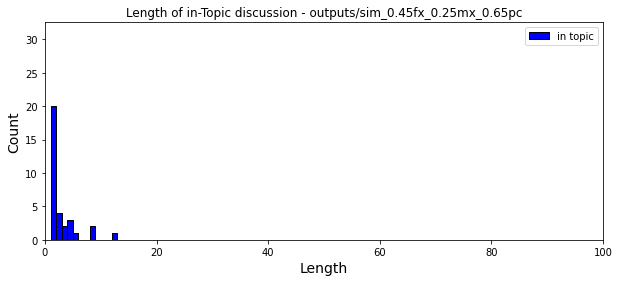

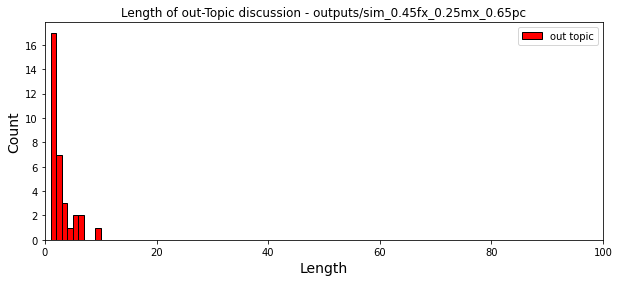

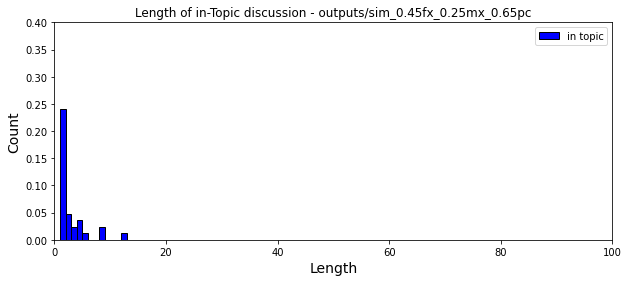

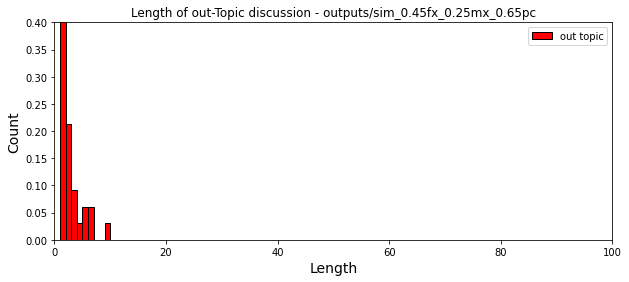

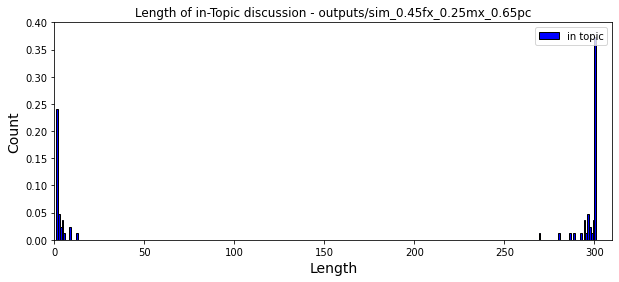

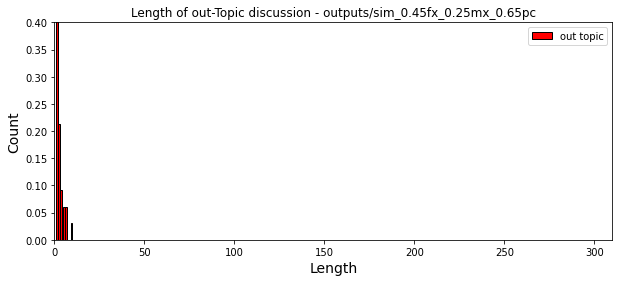



Starting Sim {code}


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50


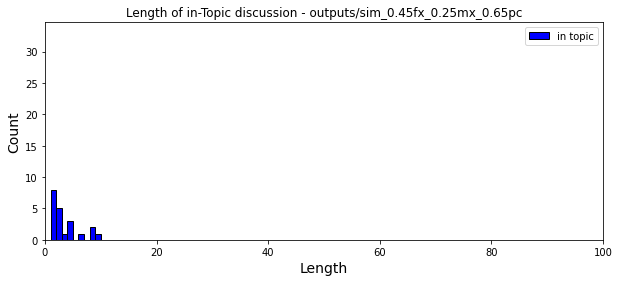

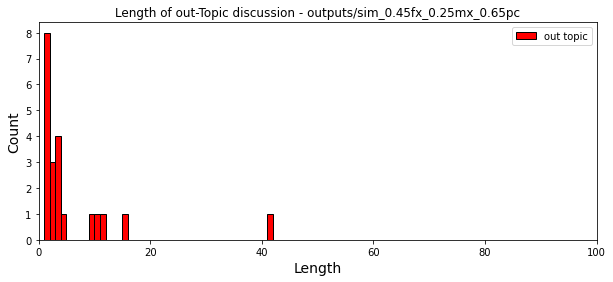

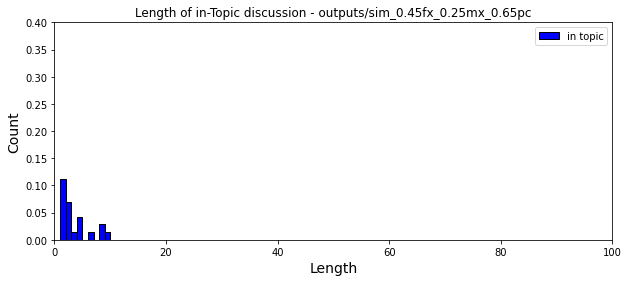

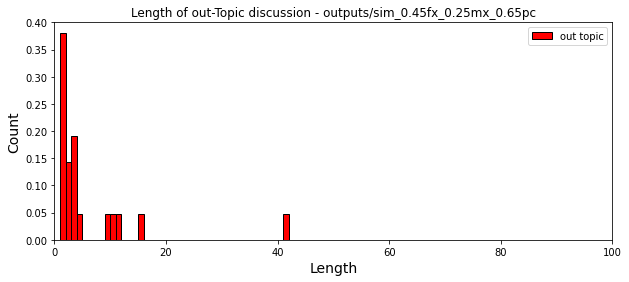

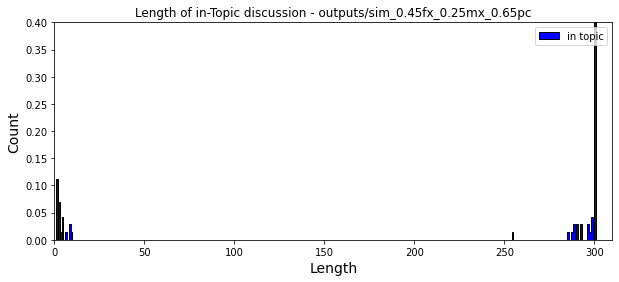

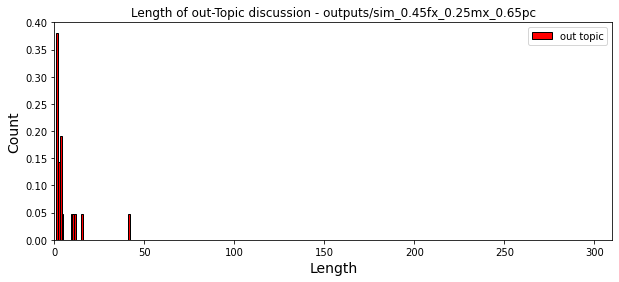



Starting Sim {code}


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50


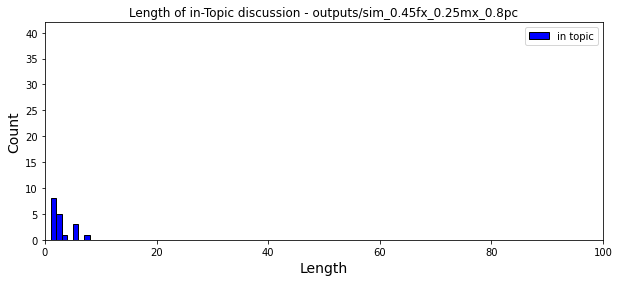

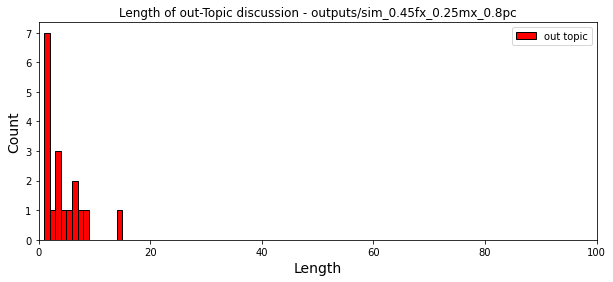

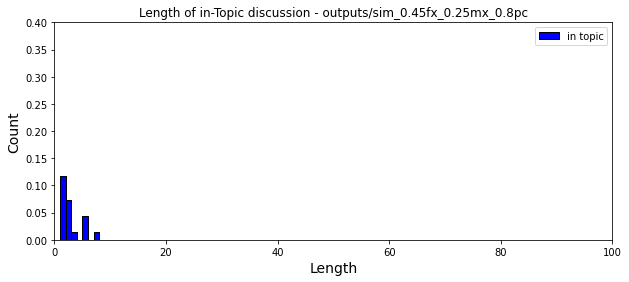

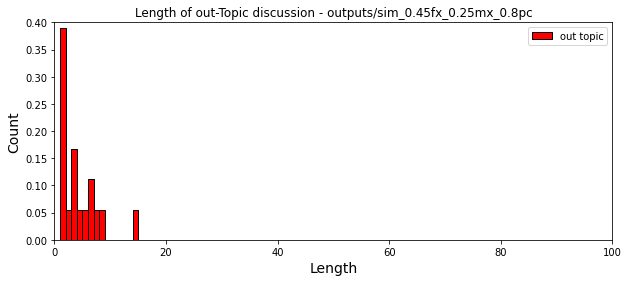

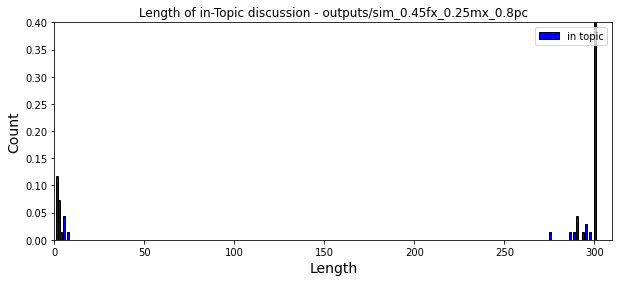

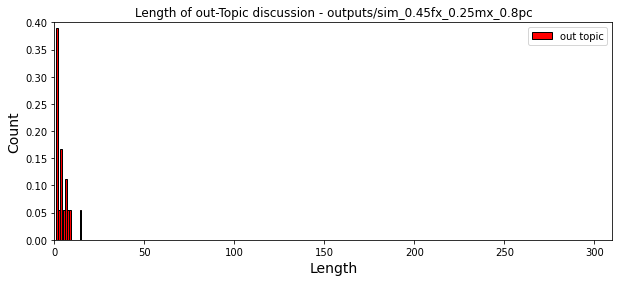



Starting Sim {code}


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50


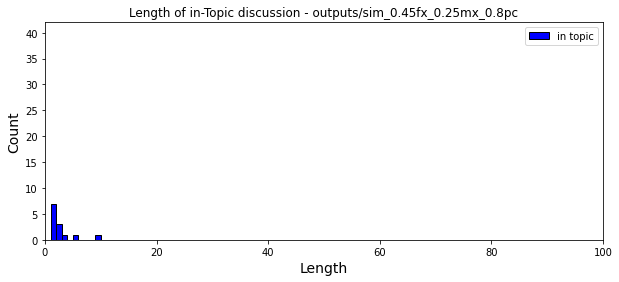

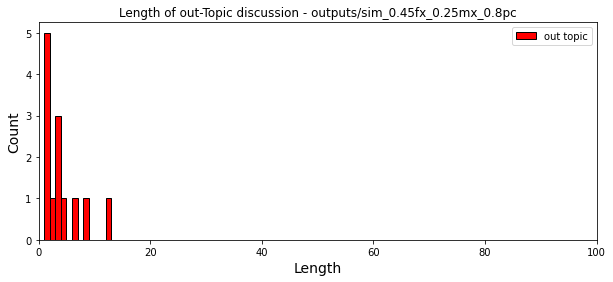

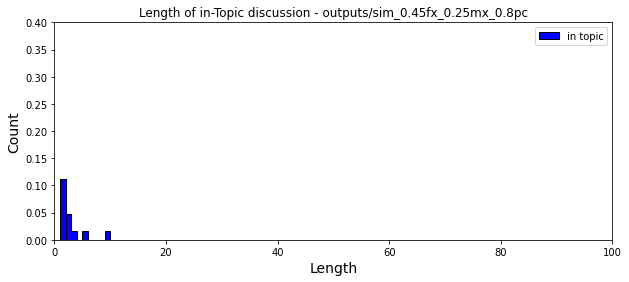

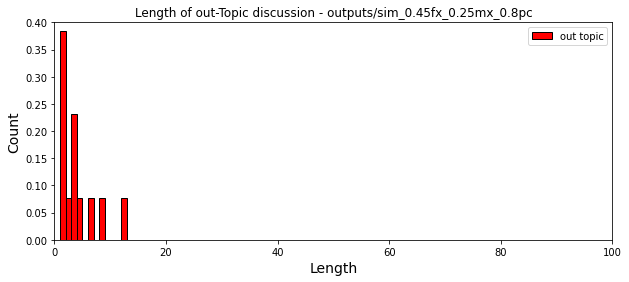

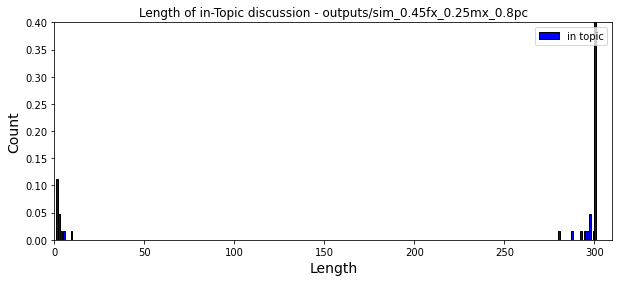

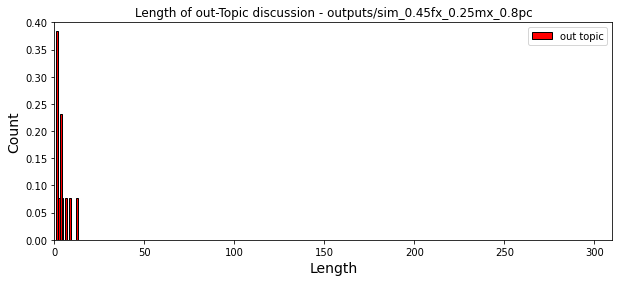



Starting Sim {code}


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50


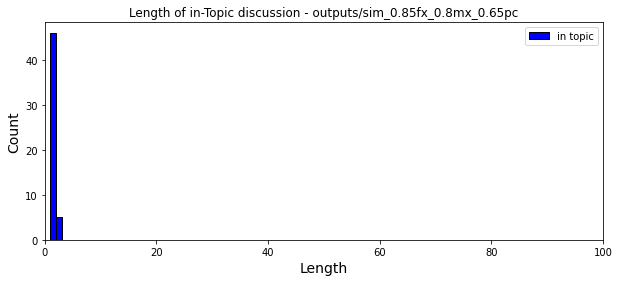

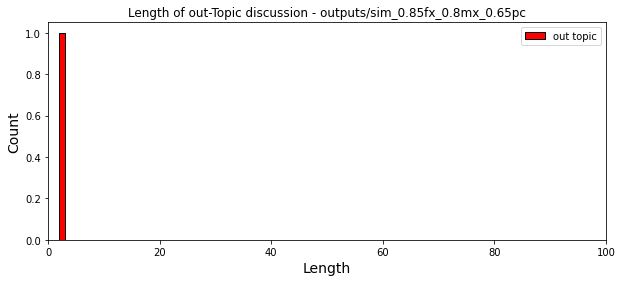

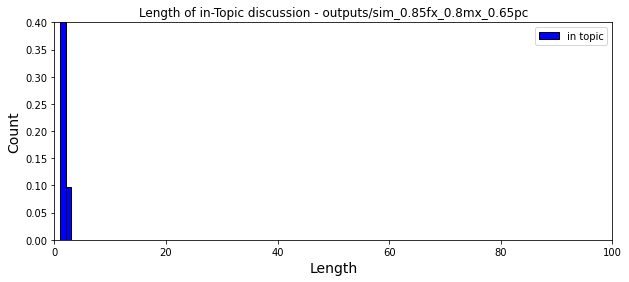

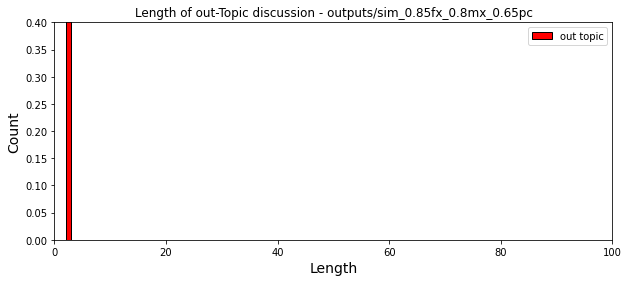

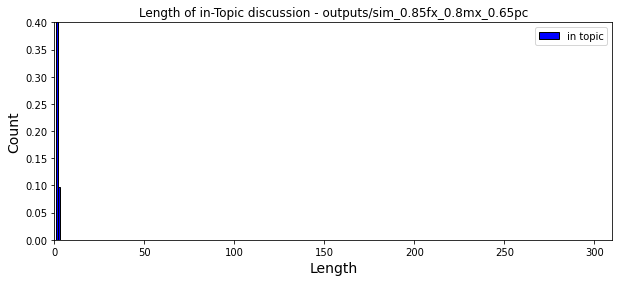

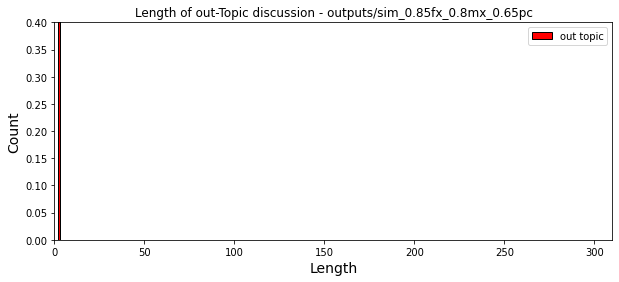



Starting Sim {code}


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50


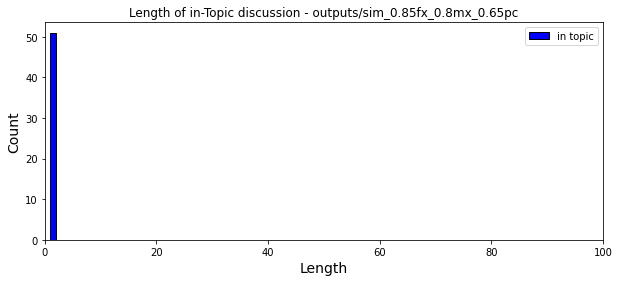

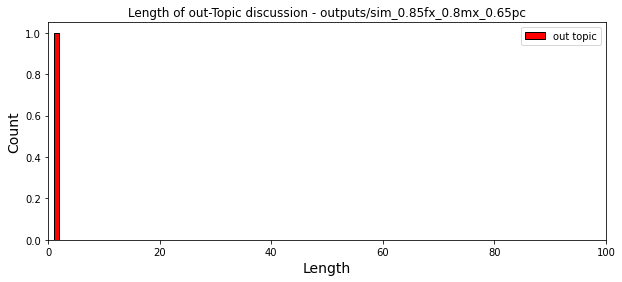

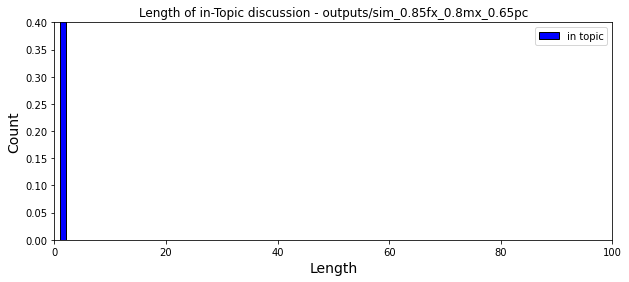

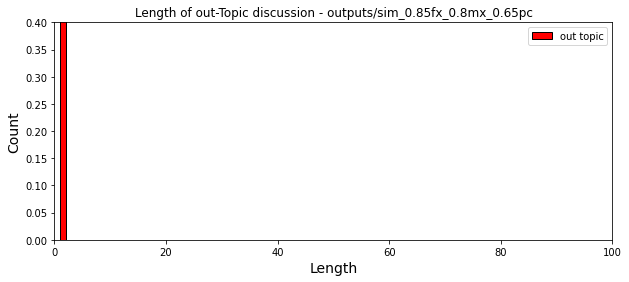

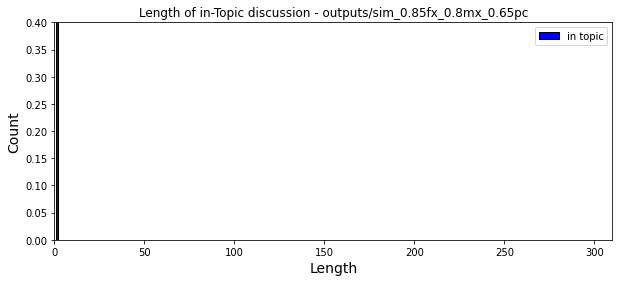

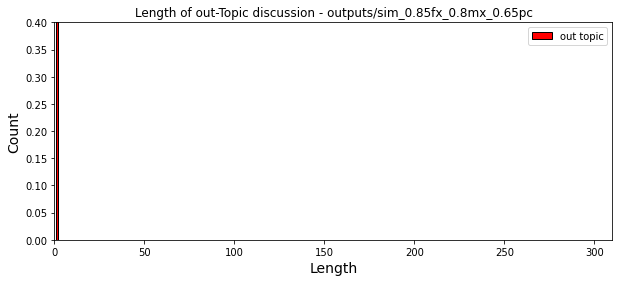



Starting Sim {code}


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


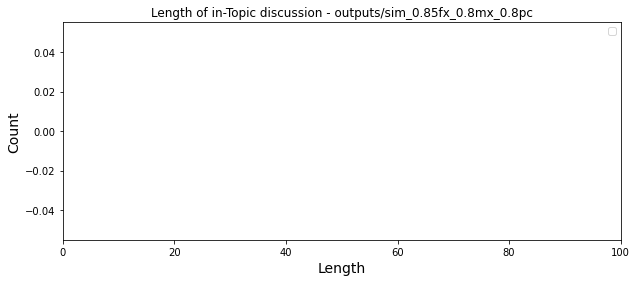

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


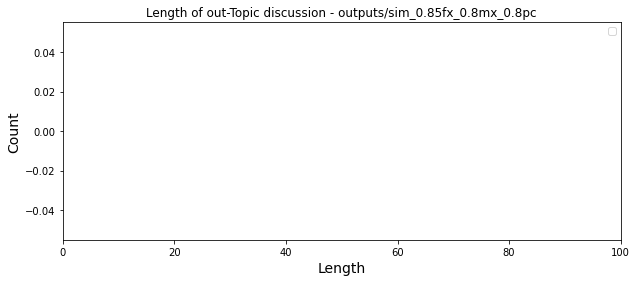

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


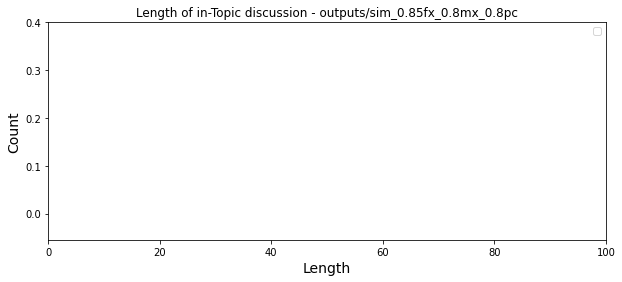

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


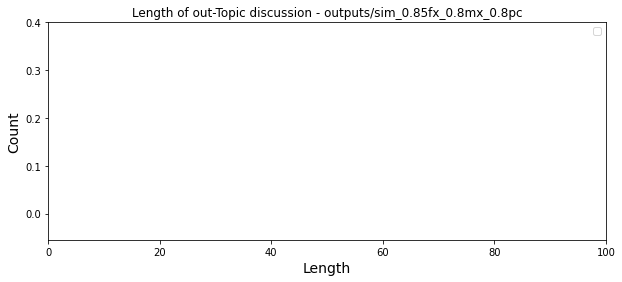

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


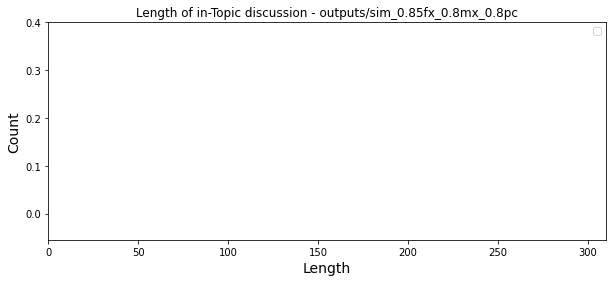

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


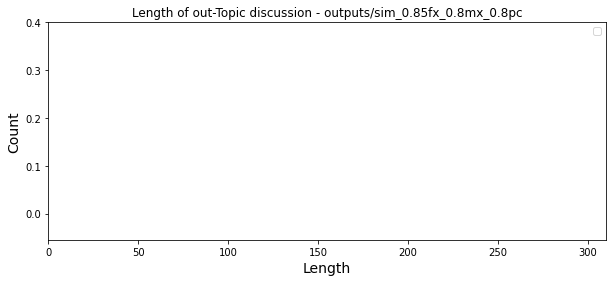



Starting Sim {code}


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


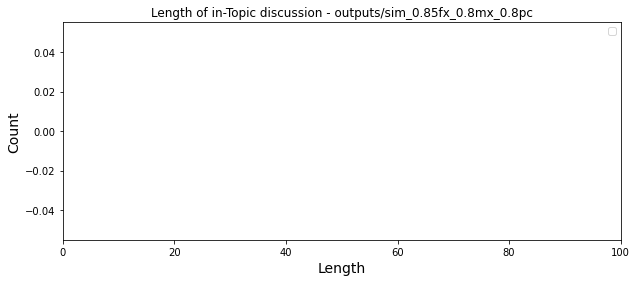

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


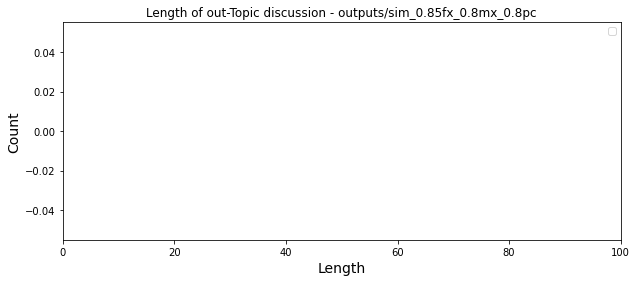

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


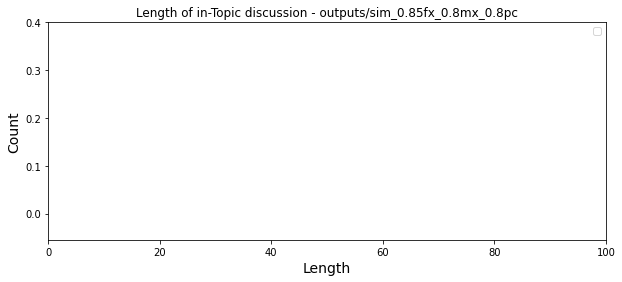

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


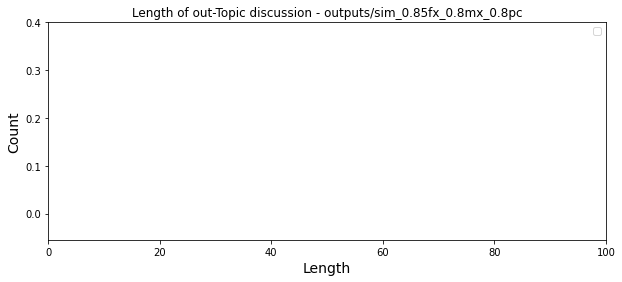

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


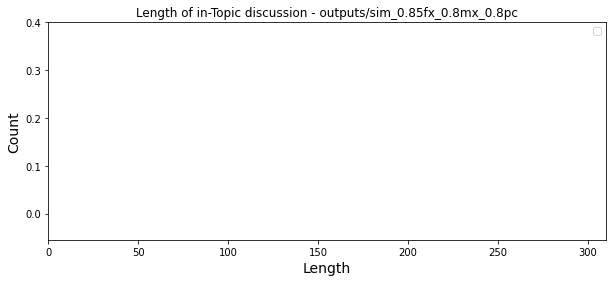

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


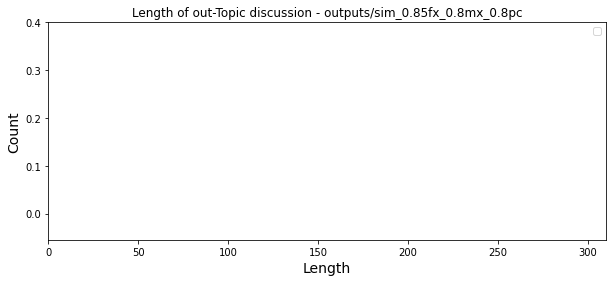



Starting Sim {code}


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50


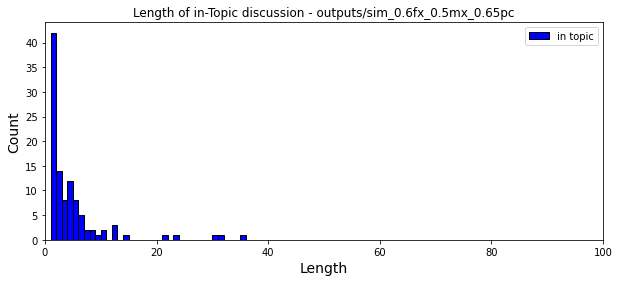

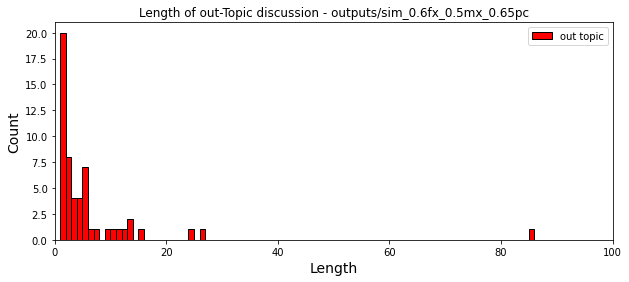

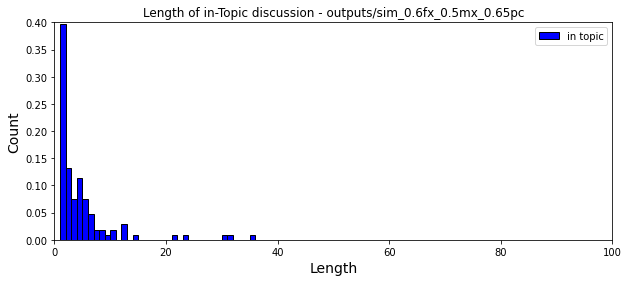

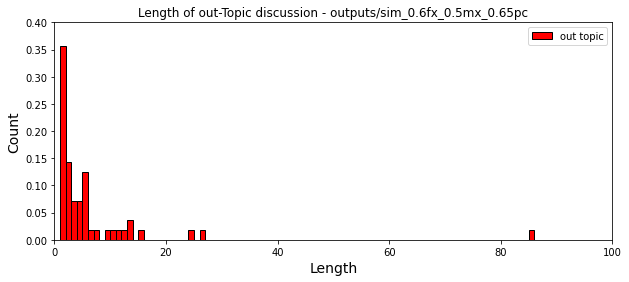

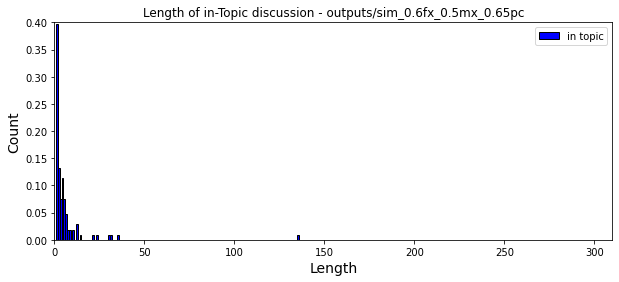

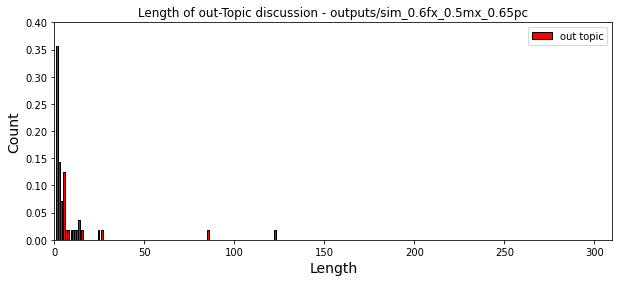



Starting Sim {code}


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50


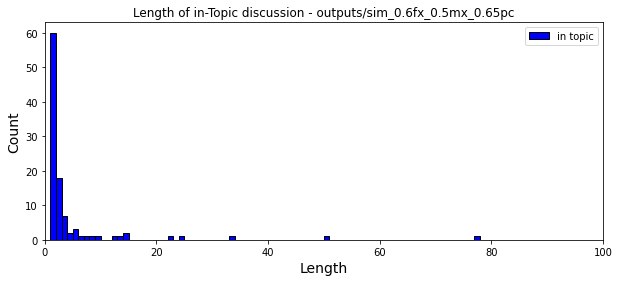

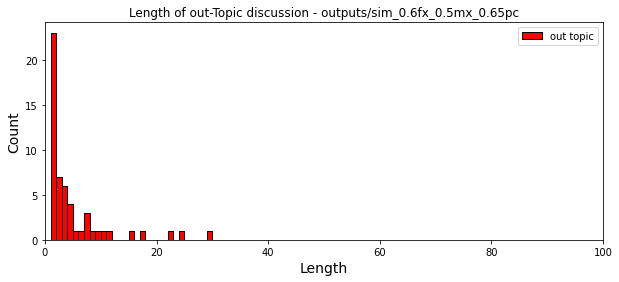

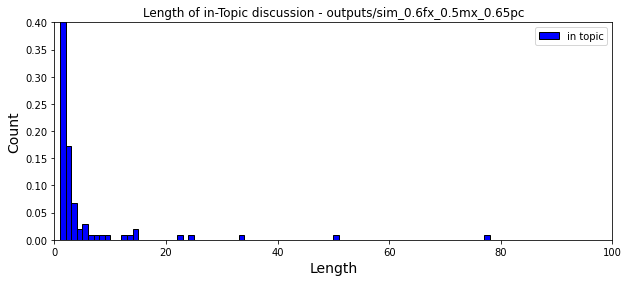

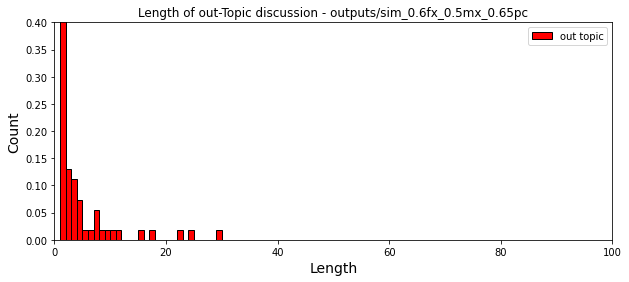

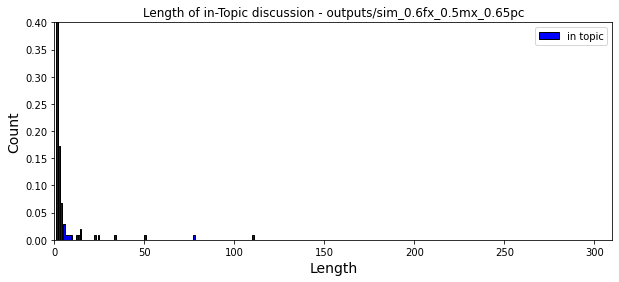

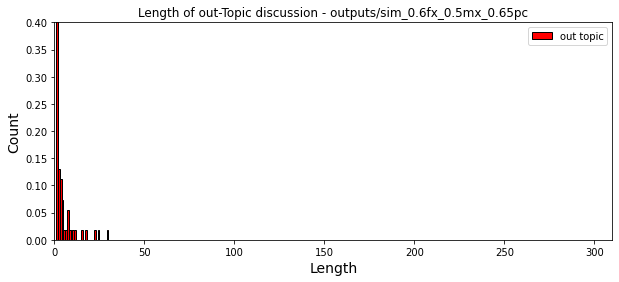



Starting Sim {code}


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50


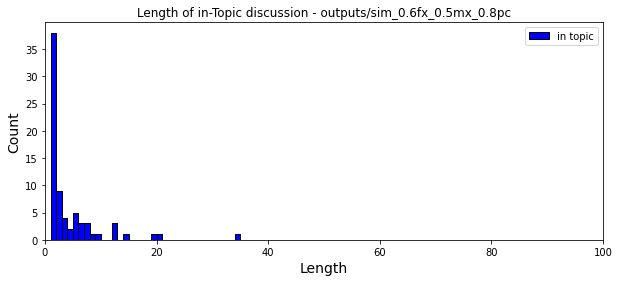

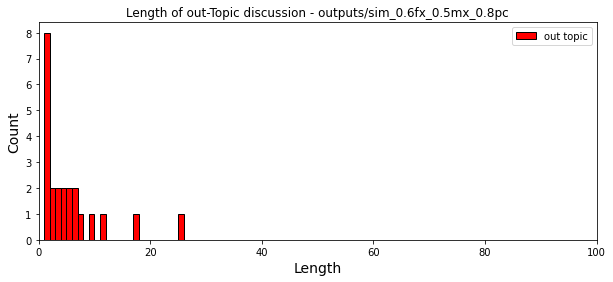

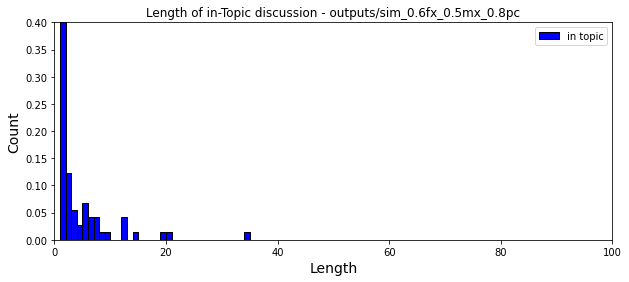

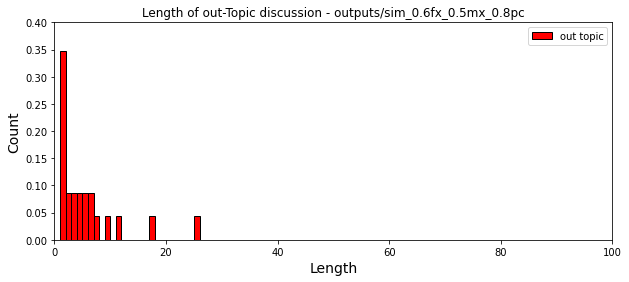

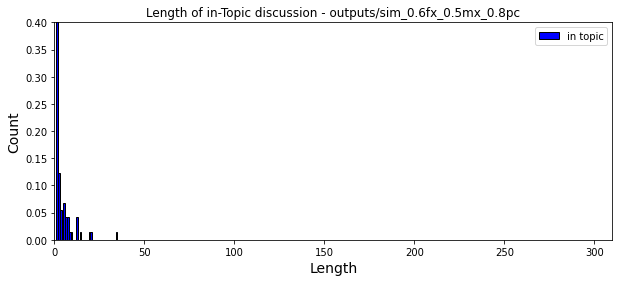

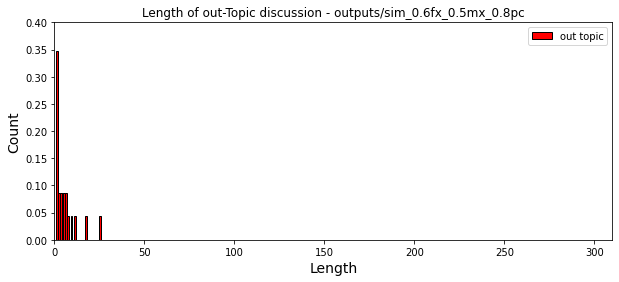



Starting Sim {code}


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50


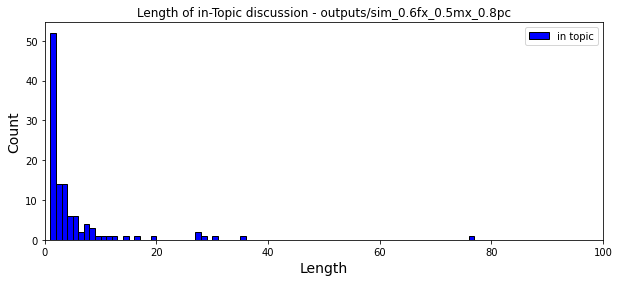

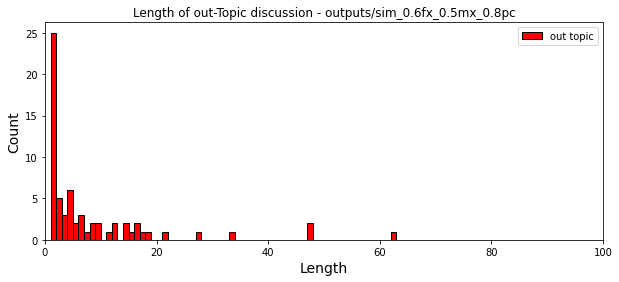

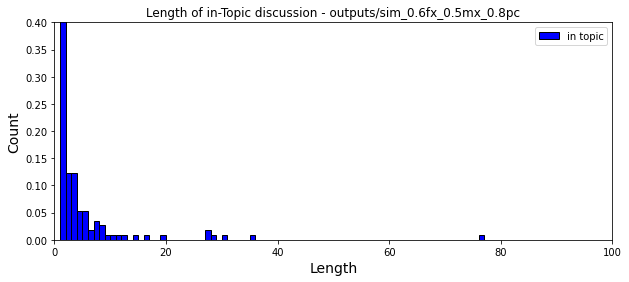

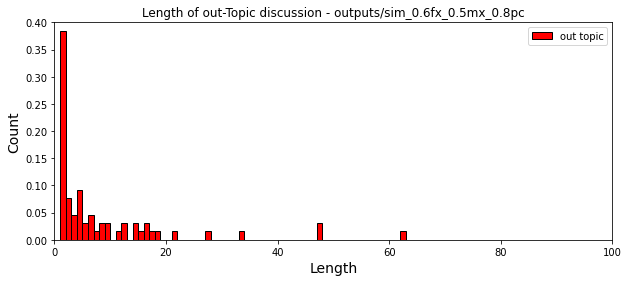

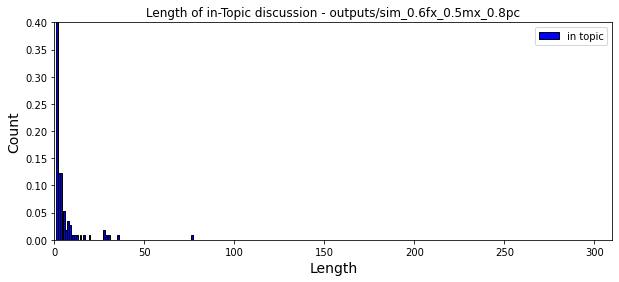

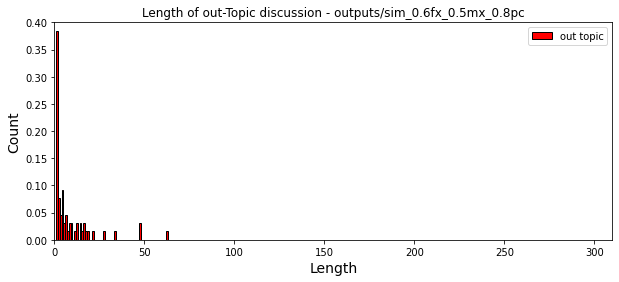

In [11]:
for code, [f, m, fx, mx, pc] in new_scenarios.items():
    print(f"\n\nStarting Sim {code}\n\n")
    # sim options
    simulation_times = 50
    iterations = 300

    reported_columns = [
        "compat_ratio", 
        "[ratio] of one-of boards", 
        "length last [board_history] of one-of boards"
    ]

    netlogo.command(f"set female_prob_exploit {fx}")
    netlogo.command(f"set male_prob_exploit {mx}")
    netlogo.command(f"set posting_chance {pc}")
    netlogo.command("set number_of_agents 15")
    netlogo.command(f'set Method "Attention Norm"')

    # create path if it doesnt exist yet
    folder_path = f"outputs/sim_{fx}fx_{mx}mx_{pc}pc"
    if not os.path.exists(folder_path): os.makedirs(folder_path) 

    in_topic = []
    out_topic = []

    for i in range(1, simulation_times + 1):
        print(f"iter {i}")

        netlogo.command("setup")
        curr_path = f"{folder_path}/{i}.csv"
        
        report = netlogo.repeat_report(reported_columns, iterations)
        report = fix_col_names(report)

        # write to file
        report.to_csv(curr_path)                
        
        in_, out_ = split_topics(report["Topic Divergence"].astype(int))
        in_topic += in_
        out_topic += out_

    plot_one_topic_histogram(in_topic, "in", folder_path, normalised = False)
    plot_one_topic_histogram(out_topic, "out", folder_path, normalised = False)
    plot_one_topic_histogram(in_topic, "in", folder_path, normalised = True)
    plot_one_topic_histogram(out_topic, "out", folder_path, normalised = True)
    plot_one_topic_histogram(in_topic, "in", folder_path, normalised = True, xlim = iterations + 10)
    plot_one_topic_histogram(out_topic, "out", folder_path, normalised = True, xlim = iterations + 10)

We now have all the simulation data stored, read and visualized, ready for interpretation